In [2]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
from tqdm import tqdm

## Use Export_ImageCollection_fromGee notebook data to detect irrigation events

## Use Sentinel_1_grd notebook data to detect irrigation events

In [2]:
path = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/idm_test/whr_s1_ndvi30.geojson'
gdf = gpd.read_file(path).iloc[:,1:]

#Create 4 Groups of similiar conditions and sort time series afte patch numbers
ms1 = gdf[(gdf['sentinel'] == 'A') & (gdf['orbit'] == 'descending')].sort_values(['patch','date'])
ms2 = gdf[(gdf['sentinel'] == 'B') & (gdf['orbit'] == 'descending')].sort_values(['patch','date'])
as1 = gdf[(gdf['sentinel'] == 'A') & (gdf['orbit'] == 'ascending')].sort_values(['patch','date'])
as2 = gdf[(gdf['sentinel'] == 'B') & (gdf['orbit'] == 'ascending')].sort_values(['patch','date'])

def add_change(gdf, column):
    col_name = '%s_change' %(column)
    gdf[col_name] = gdf[column] - gdf.shift(1)[column]
    return gdf

def add_enviromental_data(gdf):
    EVAPO_R = xr.open_dataset(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\datasets\EVAPOTRANSPIRATION_REAL.nc')
    RADOLAN = xr.open_dataset(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\datasets\RADOLAN_1km.nc')
    
    precipitation = list()
    evapo_r = list()
    
    df_pp = RADOLAN.SF.to_dataframe().reset_index()
    gdf_pp = gpd.GeoDataFrame(df_pp, geometry=gpd.points_from_xy(df_pp.lon,df_pp.lat))
    
    #iter through 
    for i, row_ini, row_next in zip(tqdm(range(len(gdf))),gdf.itertuples(),gdf.shift(-1).itertuples()):
        date_ini = row_ini.date
        date_next = row_next.date
        point = (row_ini.geometry.centroid.x, row_ini.geometry.centroid.y)
        try:
            precipitation.append(gdf_pp[(gdf_pp.within(row_ini.geometry)) & (gdf_pp.time >= date_ini) & (gdf_pp.time <= date_next)].groupby('time').mean()['SF'].sum())
            evapo_r.append(float(EVAPO_R.sel(lon=point[0], lat=point[1], method='nearest').sel(time=slice(date_ini, date_next)).evapo_r.mean()))
        except:
            precipitation.append(-999)
            evapo_r.append(-999)
    gdf['evapotranspiration_real'] = evapo_r
    gdf['precipitation'] = precipitation
    gdf[['evapotranspiration_real','precipitation']] = gdf[['evapotranspiration_real','precipitation']].shift(1)
    return gdf

ms1 = add_change(ms1,'VV')
ms2 = add_change(ms2,'VV')
as1 = add_change(as1,'VV')
as2 = add_change(as2,'VV')

ms1 = add_enviromental_data(ms1)
ms2 = add_enviromental_data(ms2)
as1 = add_enviromental_data(as1)
as2 = add_enviromental_data(as2)

gdf = gpd.GeoDataFrame(pd.concat([ms1,ms2,as1,as2]))
gdf.dropna(inplace=True)
gdf = gdf.astype({'patch': 'int', 'sentinel': 'string', 'orbit': 'string', 'identifier': 'string'})
gdf['date'] = pd.to_datetime(gdf['date'])
gdf.to_file(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/idm_test/whr_s1_ndvi30_full.geojson')


100%|██████████████████████████████████████████████████████████████████████████████| 1064/1064 [53:18<00:00,  3.01s/it]


In [4]:
ds_plot

,id,Map,NDVI,geometry
0,S1A_IW_GRDH_1SDV_20160302T054202_20160302T0542...,NaN,NaN,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
1,S1A_IW_GRDH_1SDV_20160305T171543_20160305T1716...,NaN,NaN,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
2,S1A_IW_GRDH_1SDV_20160309T053351_20160309T0534...,NaN,NaN,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
3,S1A_IW_GRDH_1SDV_20160314T054155_20160314T0542...,40.0,0.104943,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
4,S1A_IW_GRDH_1SDV_20160321T053402_20160321T0534...,40.0,0.104943,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
...,...,...,...,...
915,S1B_IW_GRDH_1SDV_20211011T171556_20211011T1716...,40.0,0.271385,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
916,S1B_IW_GRDH_1SDV_20211015T053349_20211015T0534...,40.0,0.271385,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
917,S1B_IW_GRDH_1SDV_20211020T054156_20211020T0542...,40.0,0.167487,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."
918,S1B_IW_GRDH_1SDV_20211023T171557_20211023T1716...,40.0,0.167487,"POLYGON ((8.50042 49.93947, 8.50000 49.93861, ..."


In [5]:
#Time Series iteration to append change value p
path_plot = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/gg_test_field/plot/gg_test_field_1_plot.geojson'
path_grid = 'C://Users/USER/Desktop/Master_Irrigation/03_GIS/gg_test_field/grid/gg_test_field_1_grid.geojson'

ds_plot = gpd.read_file(path_plot)
ds_grid = gpd.read_file(path_grid)
merged = ds_plot.merge(ds_grid, on='date', suffixes=('_p', '_g'))[["id_p","VH_p","VV_p","angle_p","date" ,"sentinel_p","orbit_p","geometry_p","VH_g","VV_g","angle_g","geometry_p"]]

In [6]:
# p value
p = []
deltapairs = []
# For each value and value + 1 stop 1 before to produce last delta
for index, row in merged[:].iterrows():
    try:
        p1 = merged[merged.index == index + 1]['VV_p']
        p2 = row['VV_p']
        deltap = p2 - p1
        deltap = float(deltap)
        g1 = merged[merged.index == index + 1]['VV_g']
        g2 = row['VV_g']
        deltag = g2-g1
        deltag = float(deltag)
        deltapairs.append((deltap,deltag))
        #decrease p = drought, increase g = rain
        if deltap <= 0 or deltag >= 1: # Decrease in plot == drought, increase in grid == rainfall
            p.append(0)
        elif deltap < 0.5 and deltag <= 1: # and ssm > 20%Vol:
            p.append(25)
        elif 0 <= deltap <= 1 and deltag <= 0.5:
            p.append(50)
        elif deltap >= 1 and deltag < 0.5:
            p.append(100)
        else:
            p.append(-999)  
    except:
        p.append(-999)

merged['p'] = p

In [7]:
merged['date'] = pd.to_datetime(merged['date'])
merged.set_index('date', inplace=True)

In [8]:
merged['p'][merged['p'] >= 0]

date
2016-03-14 05:41:55      0
2016-03-21 05:34:02      0
2016-03-29 17:15:43      0
2016-04-02 05:33:52    100
2016-04-07 05:41:59      0
                      ... 
2021-10-08 05:41:55      0
2021-10-11 17:15:56      0
2021-10-15 05:33:49      0
2021-10-20 05:41:56      0
2021-10-23 17:15:57     25
Name: p, Length: 808, dtype: int64

(<Figure size 900x734.4 with 7 Axes>,
 array([<AxesSubplot:ylabel='2016'>, <AxesSubplot:ylabel='2017'>,
        <AxesSubplot:ylabel='2018'>, <AxesSubplot:ylabel='2019'>,
        <AxesSubplot:ylabel='2020'>, <AxesSubplot:ylabel='2021'>],
       dtype=object))

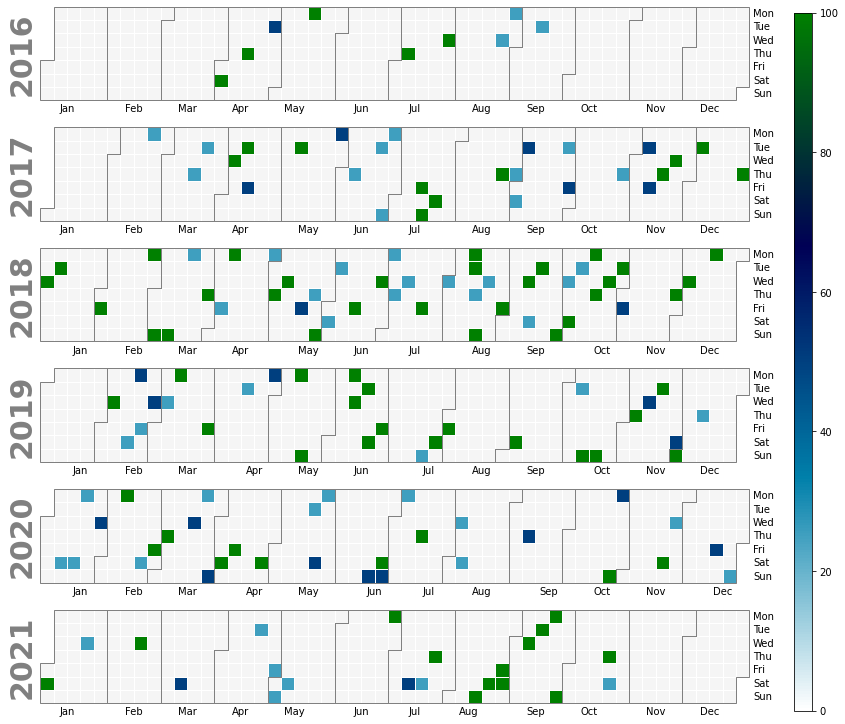

In [11]:
import calplot
import numpy as np
import pandas as pd
all_days = pd.date_range('1/3/2016', periods=365, freq='D')
days = merged.index
events = merged['p'][merged['p'] >= 0]
calplot.calplot(events, cmap='ocean_r', vmin=0)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import calmap

# Plot
plt.figure(figsize=(16,10), dpi= 80)
calmap.calendarplot(merged['p'],fig_kws={'figsize': (16,10)},cmap='YlGn', monthticks=3,dayticks=[0,2,4])
plt.show()

In [ ]:
merged[merged['p'] == -999]

In [ ]:
merged = ds_plot.merge(ds_grid, on='date', suffixes=('_p', '_g'))

In [ ]:
merged